In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
import random
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(x.size())
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuracy': train_acc,
                   f'{name} validationaccuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()
def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([8, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([8, 4, 50])
torch.Size([64, 4, 50])
torch.Size([64, 4, 50])
torch.Size([9, 4, 50])
Epoch 1: Training accuracy: 49.54379653930664 Testing 

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuracy,▁▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
centralized validationaccuracy,▁▅▅▄▅▅▅▅▆▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇█████████████
centralized training accuracy,92.33577
centralized validationaccuracy,84.67153


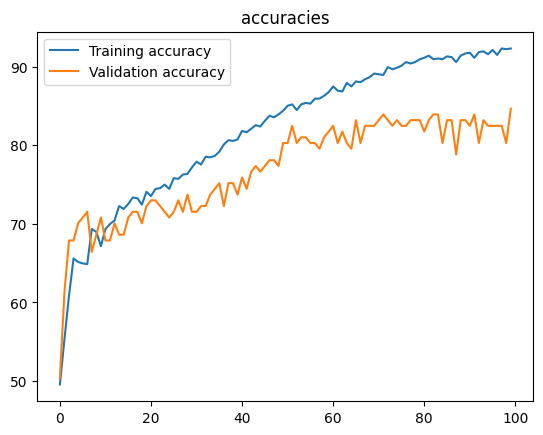

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'], name= 'centralized')
    loss, accuracy = test(net, testloader, configuration)
    print(f"Epoch {epoch+1}: Test loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

## transfer learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
0.1499999999999999
233
0.1499999999999999
310
0.1499999999999999
253


In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display



Epoch 1/100
Epoch 1: Training accuracy: 56.578948974609375 Testing accuracy: 55.042015075683594.

Epoch 2/100
Epoch 2: Training accuracy: 60.3684196472168 Testing accuracy: 57.773109436035156.

Epoch 3/100
Epoch 3: Training accuracy: 63.05263137817383 Testing accuracy: 61.974788665771484.

Epoch 4/100
Epoch 4: Training accuracy: 65.7368392944336 Testing accuracy: 64.28571319580078.

Epoch 5/100
Epoch 5: Training accuracy: 68.9473648071289 Testing accuracy: 66.59664154052734.

Epoch 6/100
Epoch 6: Training accuracy: 71.31578826904297 Testing accuracy: 69.32772827148438.

Epoch 7/100
Epoch 7: Training accuracy: 72.63157653808594 Testing accuracy: 71.21849060058594.

Epoch 8/100
Epoch 8: Training accuracy: 74.57894897460938 Testing accuracy: 72.89916229248047.

Epoch 9/100
Epoch 9: Training accuracy: 74.68421173095703 Testing accuracy: 73.10924530029297.

Epoch 10/100
Epoch 10: Training accuracy: 76.42105102539062 Testing accuracy: 74.7899169921875.

Epoch 11/100
Epoch 11: Training accur

transfer training accuracy,▁▂▄▅▆▆▇▆▇▇▇▇▇▇▇██▇██████████████████████
transfer validationaccuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇██▇█▇██████▇█████▇██▇█████▇
transfer training accuracy,86.10526
transfer validationaccuracy,77.73109


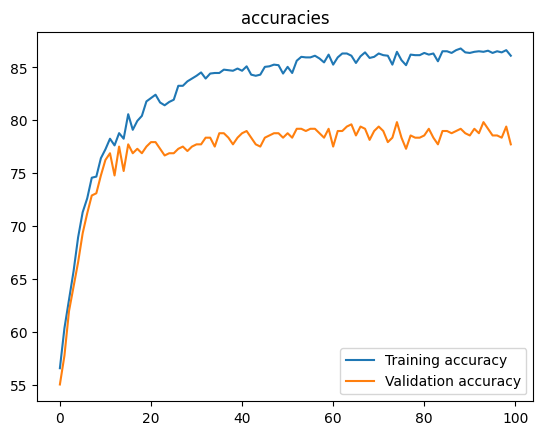

In [9]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'], name= 'transfer')
    loss, accuracy = test(net, azure_test_loader, configuration)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [11]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

In [12]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [13]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [14]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [15]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [16]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-13 23:50:55,965	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:192.168.1.146': 1.0, 'memory': 113408049767.0, 'CPU': 32.0, 'object_store_memory': 52889164185.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.045581481036017925 / accuracy 51.43403625488281
(ClientAppActor pid=3160681) 
(ClientAppActor pid=3160681) Epoch 1/100
(ClientAppActor pid=3160681) Epoch 1: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 2: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 3: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 4: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 5: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 6: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 7: Training accuracy: 49.77973556518555 Testing accuracy: 49.122806549072266.
(ClientAppActor pid=3160681) Epoch 8: Training accuracy: 49.

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.04072873382007375, {'accuracy': tensor(64.8184, device='cuda:0')}, 37.865694285952486)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=3160682) Epoch 98: Training accuracy: 50.23696517944336 Testing accuracy: 49.056602478027344. [repeated 47x across cluster]
Server-side evaluation loss 0.04072873382007375 / accuracy 64.818359375


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.040488765520208025, {'accuracy': tensor(53.8241, device='cuda:0')}, 42.29017455200665)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160682)  [repeated 409x across cluster]
(ClientAppActor pid=3160682) Epoch 100/100 [repeated 409x across cluster]
Server-side evaluation loss 0.040488765520208025 / accuracy 53.824092864990234
(ClientAppActor pid=3160681) Epoch 1: Training accuracy: 57.345970153808594 Testing accuracy: 63.20754623413086. [repeated 414x across cluster]
(ClientAppActor pid=3160682)  [repeated 72x across cluster]
(ClientAppActor pid=3160682) Epoch 44/100 [repeated 72x across cluster]
(ClientAppActor pid=3160681) Epoch 30: Training accuracy: 63.744075775146484 Testing accuracy: 61.32075500488281. [repeated 61x across cluster]
(ClientAppActor pid=3160681)  [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 58/100 [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 64: Training accuracy: 73.93364715576172 Testing accuracy: 69.81131744384766. [repeated 45x across cluster]
(ClientAppActor pid=3160681)  [repeated 96x across cluster]
(ClientAppActor pid=3160681) Ep

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.0394786280744216, {'accuracy': tensor(72.8489, device='cuda:0')}, 69.22329156799242)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.0394786280744216 / accuracy 72.84894561767578


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 222x across cluster]
(ClientAppActor pid=3160681) Epoch 8/100 [repeated 222x across cluster]
(ClientAppActor pid=3160681) Epoch 18: Training accuracy: 66.24803924560547 Testing accuracy: 62.5. [repeated 232x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.03729412134955911, {'accuracy': tensor(73.6138, device='cuda:0')}, 75.12723969097715)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03729412134955911 / accuracy 73.61376953125
(ClientAppActor pid=3160681)  [repeated 449x across cluster]
(ClientAppActor pid=3160681) Epoch 13/100 [repeated 449x across cluster]
(ClientAppActor pid=3160682) Epoch 65: Training accuracy: 74.52606964111328 Testing accuracy: 71.69811248779297. [repeated 450x across cluster]
(ClientAppActor pid=3160681)  [repeated 83x across cluster]
(ClientAppActor pid=3160681) Epoch 50/100 [repeated 83x across cluster]
(ClientAppActor pid=3160681) Epoch 50: Training accuracy: 71.44927215576172 Testing accuracy: 68.20809173583984. [repeated 72x across cluster]
(ClientAppActor pid=3160681)  [repeated 34x across cluster]
(ClientAppActor pid=3160681) Epoch 84/100 [repeated 34x across cluster]
(ClientAppActor pid=3160681) Epoch 85: Training accuracy: 72.02898406982422 Testing accuracy: 69.94219970703125. [repeated 35x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03493010997772217, {'accuracy': tensor(73.2314, device='cuda:0')}, 90.68039443495218)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.03493010997772217 / accuracy 73.23135375976562


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 31x across cluster]
(ClientAppActor pid=3160681) Epoch 12/100 [repeated 31x across cluster]
(ClientAppActor pid=3160681) Epoch 14: Training accuracy: 71.2715835571289 Testing accuracy: 71.25. [repeated 32x across cluster]
(ClientAppActor pid=3160681)  [repeated 47x across cluster]
(ClientAppActor pid=3160681) Epoch 48/100 [repeated 47x across cluster]
(ClientAppActor pid=3160681) Epoch 51: Training accuracy: 72.2135009765625 Testing accuracy: 70.0. [repeated 48x across cluster]
(ClientAppActor pid=3160681)  [repeated 146x across cluster]
(ClientAppActor pid=3160681) Epoch 84/100 [repeated 146x across cluster]
(ClientAppActor pid=3160681) Epoch 96: Training accuracy: 75.94786834716797 Testing accuracy: 71.2264175415039. [repeated 155x across cluster]
(ClientAppActor pid=3160682)  [repeated 127x across cluster]
(ClientAppActor pid=3160682) Epoch 35/100 [repeated 127x across cluster]
(ClientAppActor pid=3160682) Epoch 35: Training accuracy: 72.46376

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03272182801190544, {'accuracy': tensor(73.4226, device='cuda:0')}, 117.20354049094021)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03272182801190544 / accuracy 73.42256164550781
(ClientAppActor pid=3160681)  [repeated 178x across cluster]
(ClientAppActor pid=3160681) Epoch 1/100 [repeated 178x across cluster]
(ClientAppActor pid=3160681) Epoch 19: Training accuracy: 72.89855194091797 Testing accuracy: 68.78612518310547. [repeated 201x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.03131986014983233, {'accuracy': tensor(73.1358, device='cuda:0')}, 122.10591546795331)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03131986014983233 / accuracy 73.13575744628906
(ClientAppActor pid=3160681)  [repeated 404x across cluster]
(ClientAppActor pid=3160681) Epoch 64/100 [repeated 404x across cluster]
(ClientAppActor pid=3160681) Epoch 65: Training accuracy: 71.2715835571289 Testing accuracy: 70.0. [repeated 392x across cluster]
(ClientAppActor pid=3160681)  [repeated 83x across cluster]
(ClientAppActor pid=3160681) Epoch 3/100 [repeated 83x across cluster]
(ClientAppActor pid=3160682) Epoch 10: Training accuracy: 71.51248168945312 Testing accuracy: 71.34503173828125. [repeated 73x across cluster]
(ClientAppActor pid=3160681)  [repeated 54x across cluster]
(ClientAppActor pid=3160681) Epoch 47/100 [repeated 54x across cluster]
(ClientAppActor pid=3160681) Epoch 49: Training accuracy: 71.59420013427734 Testing accuracy: 68.78612518310547. [repeated 54x across cluster]
(ClientAppActor pid=3160682)  [repeated 64x across cluster]
(ClientAppActor pid=3160682) Epoch 31/100 [repeate

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.030518724637873033, {'accuracy': tensor(73.6138, device='cuda:0')}, 163.8955402720021)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030518724637873033 / accuracy 73.61376953125
(ClientAppActor pid=3160681)  [repeated 130x across cluster]
(ClientAppActor pid=3160681) Epoch 78/100 [repeated 130x across cluster]
(ClientAppActor pid=3160681) Epoch 77: Training accuracy: 74.20289611816406 Testing accuracy: 71.67630004882812. [repeated 129x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.02987115172778859, {'accuracy': tensor(73.3270, device='cuda:0')}, 168.96970290900208)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02987115172778859 / accuracy 73.32695770263672
(ClientAppActor pid=3160681)  [repeated 449x across cluster]
(ClientAppActor pid=3160681) Epoch 79/100 [repeated 449x across cluster]
(ClientAppActor pid=3160681) Epoch 78: Training accuracy: 74.20289611816406 Testing accuracy: 73.41040802001953. [repeated 449x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.029500828069799086, {'accuracy': tensor(73.5182, device='cuda:0')}, 173.41143997502513)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.029500828069799086 / accuracy 73.5181655883789
(ClientAppActor pid=3160681)  [repeated 278x across cluster]
(ClientAppActor pid=3160681) Epoch 13/100 [repeated 278x across cluster]
(ClientAppActor pid=3160681) Epoch 12: Training accuracy: 74.20289611816406 Testing accuracy: 72.83236694335938. [repeated 278x across cluster]
(ClientAppActor pid=3160681)  [repeated 75x across cluster]
(ClientAppActor pid=3160681) Epoch 76/100 [repeated 75x across cluster]
(ClientAppActor pid=3160681) Epoch 75: Training accuracy: 73.91304016113281 Testing accuracy: 73.41040802001953. [repeated 75x across cluster]
(ClientAppActor pid=3160681)  [repeated 87x across cluster]
(ClientAppActor pid=3160681) Epoch 52/100 [repeated 87x across cluster]
(ClientAppActor pid=3160681) Epoch 51: Training accuracy: 75.71089935302734 Testing accuracy: 71.69811248779297. [repeated 87x across cluster]
(ClientAppActor pid=3160681)  [repeated 88x across cluster]
(ClientAppActor pid=3160681) Epoch 

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.028934464735143325, {'accuracy': tensor(73.8050, device='cuda:0')}, 211.0338798329467)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=3160682)  [repeated 15x across cluster]
(ClientAppActor pid=3160682) Epoch 100/100 [repeated 15x across cluster]
(ClientAppActor pid=3160682) Epoch 99: Training accuracy: 72.52747344970703 Testing accuracy: 70.625. [repeated 15x across cluster]
Server-side evaluation loss 0.028934464735143325 / accuracy 73.80496978759766


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.028694040635052848, {'accuracy': tensor(73.7094, device='cuda:0')}, 216.02655000798404)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160682)  [repeated 400x across cluster]
(ClientAppActor pid=3160682) Epoch 100/100 [repeated 400x across cluster]
(ClientAppActor pid=3160682) Epoch 99: Training accuracy: 74.05796813964844 Testing accuracy: 73.98844146728516. [repeated 400x across cluster]
Server-side evaluation loss 0.028694040635052848 / accuracy 73.70936584472656
(ClientAppActor pid=3160682)  [repeated 138x across cluster]
(ClientAppActor pid=3160682) Epoch 93/100 [repeated 138x across cluster]
(ClientAppActor pid=3160682) Epoch 92: Training accuracy: 74.92753601074219 Testing accuracy: 73.41040802001953. [repeated 137x across cluster]
(ClientAppActor pid=3160681)  [repeated 50x across cluster]
(ClientAppActor pid=3160681) Epoch 86/100 [repeated 50x across cluster]
(ClientAppActor pid=3160681) Epoch 85: Training accuracy: 73.1554183959961 Testing accuracy: 71.25. [repeated 50x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 19/100 [

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.028460251934388104, {'accuracy': tensor(73.8050, device='cuda:0')}, 254.69466399797238)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.028460251934388104 / accuracy 73.80496978759766
(ClientAppActor pid=3160681)  [repeated 196x across cluster]
(ClientAppActor pid=3160681) Epoch 28/100 [repeated 196x across cluster]
(ClientAppActor pid=3160681) Epoch 27: Training accuracy: 71.95301055908203 Testing accuracy: 70.7602310180664. [repeated 195x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.02845568166059606, {'accuracy': tensor(74.2830, device='cuda:0')}, 259.437206055969)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02845568166059606 / accuracy 74.2829818725586
(ClientAppActor pid=3160682)  [repeated 474x across cluster]
(ClientAppActor pid=3160682) Epoch 33/100 [repeated 474x across cluster]
(ClientAppActor pid=3160682) Epoch 32: Training accuracy: 74.59618377685547 Testing accuracy: 73.09941864013672. [repeated 474x across cluster]
(ClientAppActor pid=3160681)  [repeated 78x across cluster]
(ClientAppActor pid=3160681) Epoch 27/100 [repeated 78x across cluster]
(ClientAppActor pid=3160681) Epoch 26: Training accuracy: 76.42179870605469 Testing accuracy: 74.52830505371094. [repeated 78x across cluster]
(ClientAppActor pid=3160681)  [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 57/100 [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 56: Training accuracy: 76.42179870605469 Testing accuracy: 74.52830505371094. [repeated 40x across cluster]
(ClientAppActor pid=3160681)  [repeated 36x across cluster]
(ClientAppActor pid=3160681) Epoch 8

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.028357016689637127, {'accuracy': tensor(74.0918, device='cuda:0')}, 279.2582352949539)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.028357016689637127 / accuracy 74.09178161621094


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 34x across cluster]
(ClientAppActor pid=3160681) Epoch 15/100 [repeated 34x across cluster]
(ClientAppActor pid=3160681) Epoch 14: Training accuracy: 77.36966705322266 Testing accuracy: 72.16981506347656. [repeated 33x across cluster]
(ClientAppActor pid=3160681)  [repeated 83x across cluster]
(ClientAppActor pid=3160681) Epoch 87/100 [repeated 83x across cluster]
(ClientAppActor pid=3160681) Epoch 86: Training accuracy: 76.540283203125 Testing accuracy: 72.16981506347656. [repeated 83x across cluster]
(ClientAppActor pid=3160681)  [repeated 105x across cluster]
(ClientAppActor pid=3160681) Epoch 78/100 [repeated 105x across cluster]
(ClientAppActor pid=3160681) Epoch 77: Training accuracy: 75.21739196777344 Testing accuracy: 74.56647491455078. [repeated 105x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.02802625298500061, {'accuracy': tensor(74.6654, device='cuda:0')}, 296.96719854103867)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02802625298500061 / accuracy 74.66539001464844
(ClientAppActor pid=3160682)  [repeated 193x across cluster]
(ClientAppActor pid=3160682) Epoch 100/100 [repeated 193x across cluster]
(ClientAppActor pid=3160682) Epoch 100: Training accuracy: 74.4493408203125 Testing accuracy: 73.68421173095703. [repeated 195x across cluster]
(ClientAppActor pid=3160681)  [repeated 334x across cluster]
(ClientAppActor pid=3160681) Epoch 34/100 [repeated 334x across cluster]
(ClientAppActor pid=3160681) Epoch 33: Training accuracy: 73.459716796875 Testing accuracy: 68.86792755126953. [repeated 333x across cluster]
(ClientAppActor pid=3160681)  [repeated 29x across cluster]
(ClientAppActor pid=3160681) Epoch 63/100 [repeated 29x across cluster]
(ClientAppActor pid=3160681) Epoch 62: Training accuracy: 76.89573669433594 Testing accuracy: 70.28302001953125. [repeated 29x across cluster]
(ClientAppActor pid=3160681)  [repeated 30x across cluster]
(ClientAppActor pid=3160681) Epoc

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.028073757886886597, {'accuracy': tensor(73.9962, device='cuda:0')}, 314.02147576294374)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.028073757886886597 / accuracy 73.99617767333984


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 56x across cluster]
(ClientAppActor pid=3160681) Epoch 43/100 [repeated 56x across cluster]
(ClientAppActor pid=3160681) Epoch 42: Training accuracy: 74.56829071044922 Testing accuracy: 73.125. [repeated 55x across cluster]
(ClientAppActor pid=3160681)  [repeated 176x across cluster]
(ClientAppActor pid=3160681) Epoch 9/100 [repeated 176x across cluster]
(ClientAppActor pid=3160681) Epoch 8: Training accuracy: 74.15565490722656 Testing accuracy: 73.68421173095703. [repeated 176x across cluster]
(ClientAppActor pid=3160682)  [repeated 102x across cluster]
(ClientAppActor pid=3160682) Epoch 27/100 [repeated 102x across cluster]
(ClientAppActor pid=3160682) Epoch 26: Training accuracy: 74.78260803222656 Testing accuracy: 74.56647491455078. [repeated 103x across cluster]
(ClientAppActor pid=3160682)  [repeated 10x across cluster]
(ClientAppActor pid=3160682) Epoch 37/100 [repeated 10x across cluster]
(ClientAppActor pid=3160682) Epoch 36: Training ac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.027798645636614633, {'accuracy': tensor(74.6654, device='cuda:0')}, 340.1701743749436)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027798645636614633 / accuracy 74.66539001464844
(ClientAppActor pid=3160681)  [repeated 335x across cluster]
(ClientAppActor pid=3160681) Epoch 47/100 [repeated 335x across cluster]
(ClientAppActor pid=3160681) Epoch 46: Training accuracy: 74.0088119506836 Testing accuracy: 73.09941864013672. [repeated 334x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (19, 0.0278303184930016, {'accuracy': tensor(74.1874, device='cuda:0')}, 343.8436562869465)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0278303184930016 / accuracy 74.1873779296875
(ClientAppActor pid=3160681)  [repeated 253x across cluster]
(ClientAppActor pid=3160681) Epoch 40/100 [repeated 253x across cluster]
(ClientAppActor pid=3160681) Epoch 39: Training accuracy: 75.07246398925781 Testing accuracy: 75.1445083618164. [repeated 253x across cluster]
(ClientAppActor pid=3160681)  [repeated 56x across cluster]
(ClientAppActor pid=3160681) Epoch 86/100 [repeated 56x across cluster]
(ClientAppActor pid=3160681) Epoch 85: Training accuracy: 74.49275207519531 Testing accuracy: 74.56647491455078. [repeated 56x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 20/100 [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 19: Training accuracy: 77.36966705322266 Testing accuracy: 72.64151000976562. [repeated 44x across cluster]
(ClientAppActor pid=3160681)  [repeated 79x across cluster]
(ClientAppActor pid=3160681) Epoch 89/

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.027539467110353356, {'accuracy': tensor(75.0478, device='cuda:0')}, 378.05724183493294)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027539467110353356 / accuracy 75.04779815673828
(ClientAppActor pid=3160681)  [repeated 129x across cluster]
(ClientAppActor pid=3160681) Epoch 42/100 [repeated 129x across cluster]
(ClientAppActor pid=3160681) Epoch 41: Training accuracy: 75.03924560546875 Testing accuracy: 73.75. [repeated 128x across cluster]
(ClientAppActor pid=3160681)  [repeated 272x across cluster]
(ClientAppActor pid=3160681) Epoch 50/100 [repeated 272x across cluster]
(ClientAppActor pid=3160681) Epoch 49: Training accuracy: 77.36966705322266 Testing accuracy: 71.69811248779297. [repeated 273x across cluster]
(ClientAppActor pid=3160681)  [repeated 30x across cluster]
(ClientAppActor pid=3160681) Epoch 80/100 [repeated 30x across cluster]
(ClientAppActor pid=3160681) Epoch 79: Training accuracy: 77.36966705322266 Testing accuracy: 73.11320495605469. [repeated 30x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.027447013293995577, {'accuracy': tensor(75.4302, device='cuda:0')}, 393.04078769893385)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.027447013293995577 / accuracy 75.43021392822266


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 27x across cluster]
(ClientAppActor pid=3160681) Epoch 6/100 [repeated 27x across cluster]
(ClientAppActor pid=3160681) Epoch 5: Training accuracy: 73.62637329101562 Testing accuracy: 73.125. [repeated 26x across cluster]
(ClientAppActor pid=3160681)  [repeated 89x across cluster]
(ClientAppActor pid=3160681) Epoch 85/100 [repeated 89x across cluster]
(ClientAppActor pid=3160681) Epoch 84: Training accuracy: 75.19623565673828 Testing accuracy: 74.375. [repeated 89x across cluster]
(ClientAppActor pid=3160681)  [repeated 99x across cluster]
(ClientAppActor pid=3160681) Epoch 74/100 [repeated 99x across cluster]
(ClientAppActor pid=3160681) Epoch 73: Training accuracy: 75.94203186035156 Testing accuracy: 75.72254180908203. [repeated 99x across cluster]
(ClientAppActor pid=3160682)  [repeated 141x across cluster]
(ClientAppActor pid=3160682) Epoch 36/100 [repeated 141x across cluster]
(ClientAppActor pid=3160682) Epoch 35: Training accuracy: 77.2511

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.027403659680310416, {'accuracy': tensor(75.0478, device='cuda:0')}, 413.6554599129595)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027403659680310416 / accuracy 75.04779815673828
(ClientAppActor pid=3160681)  [repeated 112x across cluster]
(ClientAppActor pid=3160681) Epoch 40/100 [repeated 112x across cluster]
(ClientAppActor pid=3160681) Epoch 39: Training accuracy: 74.56829071044922 Testing accuracy: 74.375. [repeated 111x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.027496939196306115, {'accuracy': tensor(74.8566, device='cuda:0')}, 418.3873049459653)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027496939196306115 / accuracy 74.85659790039062
(ClientAppActor pid=3160681)  [repeated 443x across cluster]
(ClientAppActor pid=3160681) Epoch 30/100 [repeated 443x across cluster]
(ClientAppActor pid=3160681) Epoch 29: Training accuracy: 77.13269805908203 Testing accuracy: 73.58490753173828. [repeated 443x across cluster]
(ClientAppActor pid=3160682)  [repeated 244x across cluster]
(ClientAppActor pid=3160682) Epoch 35/100 [repeated 244x across cluster]
(ClientAppActor pid=3160682) Epoch 34: Training accuracy: 76.3768081665039 Testing accuracy: 73.41040802001953. [repeated 245x across cluster]
(ClientAppActor pid=3160682)  [repeated 11x across cluster]
(ClientAppActor pid=3160682) Epoch 46/100 [repeated 11x across cluster]
(ClientAppActor pid=3160682) Epoch 45: Training accuracy: 75.94203186035156 Testing accuracy: 75.72254180908203. [repeated 11x across cluster]
(ClientAppActor pid=3160682)  [repeated 11x across cluster]
(ClientAppActor pid=3160682) Epo

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.02780727779164034, {'accuracy': tensor(74.1874, device='cuda:0')}, 456.0128587259678)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02780727779164034 / accuracy 74.1873779296875


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 15x across cluster]
(ClientAppActor pid=3160681) Epoch 3/100 [repeated 15x across cluster]
(ClientAppActor pid=3160681) Epoch 2: Training accuracy: 76.3768081665039 Testing accuracy: 73.41040802001953. [repeated 15x across cluster]
(ClientAppActor pid=3160681)  [repeated 386x across cluster]
(ClientAppActor pid=3160681) Epoch 89/100 [repeated 386x across cluster]
(ClientAppActor pid=3160681) Epoch 88: Training accuracy: 75.18355560302734 Testing accuracy: 73.09941864013672. [repeated 386x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.02740257452515995, {'accuracy': tensor(74.7610, device='cuda:0')}, 461.6325248830253)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02740257452515995 / accuracy 74.76099395751953
(ClientAppActor pid=3160681)  [repeated 260x across cluster]
(ClientAppActor pid=3160681) Epoch 98/100 [repeated 260x across cluster]
(ClientAppActor pid=3160681) Epoch 97: Training accuracy: 74.59618377685547 Testing accuracy: 73.09941864013672. [repeated 259x across cluster]
(ClientAppActor pid=3160681)  [repeated 45x across cluster]
(ClientAppActor pid=3160681) Epoch 35/100 [repeated 45x across cluster]
(ClientAppActor pid=3160681) Epoch 34: Training accuracy: 76.3768081665039 Testing accuracy: 75.72254180908203. [repeated 45x across cluster]
(ClientAppActor pid=3160681)  [repeated 41x across cluster]
(ClientAppActor pid=3160681) Epoch 68/100 [repeated 41x across cluster]
(ClientAppActor pid=3160681) Epoch 67: Training accuracy: 76.52173614501953 Testing accuracy: 75.1445083618164. [repeated 41x across cluster]
(ClientAppActor pid=3160682)  [repeated 42x across cluster]
(ClientAppActor pid=3160682) Epoch 77

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.02736031307893641, {'accuracy': tensor(74.8566, device='cuda:0')}, 494.46221054601483)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02736031307893641 / accuracy 74.85659790039062


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 211x across cluster]
(ClientAppActor pid=3160681) Epoch 93/100 [repeated 211x across cluster]
(ClientAppActor pid=3160681) Epoch 92: Training accuracy: 75.18355560302734 Testing accuracy: 72.51461791992188. [repeated 210x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.027442541192559636, {'accuracy': tensor(74.6654, device='cuda:0')}, 501.9652692269301)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027442541192559636 / accuracy 74.66539001464844
(ClientAppActor pid=3160681)  [repeated 280x across cluster]
(ClientAppActor pid=3160681) Epoch 69/100 [repeated 280x across cluster]
(ClientAppActor pid=3160681) Epoch 68: Training accuracy: 75.03924560546875 Testing accuracy: 75.0. [repeated 280x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.027272087686202106, {'accuracy': tensor(74.9522, device='cuda:0')}, 506.88289021293167)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027272087686202106 / accuracy 74.95220184326172
(ClientAppActor pid=3160681)  [repeated 410x across cluster]
(ClientAppActor pid=3160681) Epoch 32/100 [repeated 410x across cluster]
(ClientAppActor pid=3160681) Epoch 31: Training accuracy: 75.65217590332031 Testing accuracy: 75.1445083618164. [repeated 410x across cluster]
(ClientAppActor pid=3160681)  [repeated 87x across cluster]
(ClientAppActor pid=3160681) Epoch 67/100 [repeated 87x across cluster]
(ClientAppActor pid=3160681) Epoch 66: Training accuracy: 76.81159210205078 Testing accuracy: 75.72254180908203. [repeated 87x across cluster]
(ClientAppActor pid=3160681)  [repeated 42x across cluster]
(ClientAppActor pid=3160681) Epoch 1/100 [repeated 42x across cluster]
(ClientAppActor pid=3160681) Epoch 100: Training accuracy: 76.23188781738281 Testing accuracy: 71.0982666015625. [repeated 42x across cluster]
(ClientAppActor pid=3160681)  [repeated 45x across cluster]
(ClientAppActor pid=3160681) Epoch 3

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.027116374057881972, {'accuracy': tensor(75.5258, device='cuda:0')}, 545.7235353320139)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027116374057881972 / accuracy 75.52581024169922
(ClientAppActor pid=3160681)  [repeated 333x across cluster]
(ClientAppActor pid=3160681) Epoch 94/100 [repeated 333x across cluster]
(ClientAppActor pid=3160681) Epoch 93: Training accuracy: 77.7251205444336 Testing accuracy: 75.0. [repeated 332x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.02707660724135006, {'accuracy': tensor(75.8126, device='cuda:0')}, 550.5803288590396)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02707660724135006 / accuracy 75.8126220703125
(ClientAppActor pid=3160681)  [repeated 198x across cluster]
(ClientAppActor pid=3160681) Epoch 23/100 [repeated 198x across cluster]
(ClientAppActor pid=3160681) Epoch 22: Training accuracy: 77.8436050415039 Testing accuracy: 71.69811248779297. [repeated 198x across cluster]
(ClientAppActor pid=3160682)  [repeated 44x across cluster]
(ClientAppActor pid=3160682) Epoch 95/100 [repeated 44x across cluster]
(ClientAppActor pid=3160682) Epoch 94: Training accuracy: 75.35321807861328 Testing accuracy: 75.0. [repeated 44x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 90/100 [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 89: Training accuracy: 78.19905090332031 Testing accuracy: 70.75471496582031. [repeated 44x across cluster]
(ClientAppActor pid=3160681)  [repeated 93x across cluster]
(ClientAppActor pid=3160681) Epoch 73/100 [repeate

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.027164219056858736, {'accuracy': tensor(74.9522, device='cuda:0')}, 586.2844446579693)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027164219056858736 / accuracy 74.95220184326172
(ClientAppActor pid=3160682)  [repeated 353x across cluster]
(ClientAppActor pid=3160682) Epoch 31/100 [repeated 353x across cluster]
(ClientAppActor pid=3160682) Epoch 30: Training accuracy: 76.3768081665039 Testing accuracy: 73.98844146728516. [repeated 353x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.027092518175349516, {'accuracy': tensor(75.4302, device='cuda:0')}, 591.257609252003)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027092518175349516 / accuracy 75.43021392822266
(ClientAppActor pid=3160681)  [repeated 306x across cluster]
(ClientAppActor pid=3160681) Epoch 92/100 [repeated 306x across cluster]
(ClientAppActor pid=3160681) Epoch 91: Training accuracy: 76.23188781738281 Testing accuracy: 73.41040802001953. [repeated 305x across cluster]
(ClientAppActor pid=3160681)  [repeated 68x across cluster]
(ClientAppActor pid=3160681) Epoch 51/100 [repeated 68x across cluster]
(ClientAppActor pid=3160681) Epoch 50: Training accuracy: 74.25431823730469 Testing accuracy: 72.5. [repeated 68x across cluster]
(ClientAppActor pid=3160682)  [repeated 58x across cluster]
(ClientAppActor pid=3160682) Epoch 63/100 [repeated 58x across cluster]
(ClientAppActor pid=3160682) Epoch 62: Training accuracy: 77.36966705322266 Testing accuracy: 74.52830505371094. [repeated 59x across cluster]
(ClientAppActor pid=3160682)  [repeated 8x across cluster]
(ClientAppActor pid=3160682) Epoch 71/100 [repea

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.02708820385091445, {'accuracy': tensor(75.4302, device='cuda:0')}, 625.1620387759758)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02708820385091445 / accuracy 75.43021392822266
(ClientAppActor pid=3160681)  [repeated 76x across cluster]
(ClientAppActor pid=3160681) Epoch 62/100 [repeated 76x across cluster]
(ClientAppActor pid=3160681) Epoch 61: Training accuracy: 74.4493408203125 Testing accuracy: 72.51461791992188. [repeated 75x across cluster]
(ClientAppActor pid=3160682)  [repeated 301x across cluster]
(ClientAppActor pid=3160682) Epoch 67/100 [repeated 301x across cluster]
(ClientAppActor pid=3160682) Epoch 66: Training accuracy: 75.0 Testing accuracy: 70.28302001953125. [repeated 302x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.026922559036928063, {'accuracy': tensor(75.7170, device='cuda:0')}, 633.4991843409371)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.026922559036928063 / accuracy 75.7170181274414
(ClientAppActor pid=3160681)  [repeated 342x across cluster]
(ClientAppActor pid=3160681) Epoch 57/100 [repeated 342x across cluster]
(ClientAppActor pid=3160681) Epoch 56: Training accuracy: 74.72527313232422 Testing accuracy: 73.75. [repeated 341x across cluster]
(ClientAppActor pid=3160681)  [repeated 85x across cluster]
(ClientAppActor pid=3160681) Epoch 94/100 [repeated 85x across cluster]
(ClientAppActor pid=3160681) Epoch 93: Training accuracy: 74.41130065917969 Testing accuracy: 73.125. [repeated 86x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.026940408874960506, {'accuracy': tensor(75.7170, device='cuda:0')}, 642.5802001010161)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.026940408874960506 / accuracy 75.7170181274414


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 39x across cluster]
(ClientAppActor pid=3160681) Epoch 26/100 [repeated 39x across cluster]
(ClientAppActor pid=3160681) Epoch 25: Training accuracy: 73.459716796875 Testing accuracy: 74.05660247802734. [repeated 38x across cluster]
(ClientAppActor pid=3160681)  [repeated 77x across cluster]
(ClientAppActor pid=3160681) Epoch 93/100 [repeated 77x across cluster]
(ClientAppActor pid=3160681) Epoch 92: Training accuracy: 78.55450439453125 Testing accuracy: 75.47169494628906. [repeated 77x across cluster]
(ClientAppActor pid=3160681)  [repeated 91x across cluster]
(ClientAppActor pid=3160681) Epoch 74/100 [repeated 91x across cluster]
(ClientAppActor pid=3160681) Epoch 73: Training accuracy: 78.55072784423828 Testing accuracy: 73.98844146728516. [repeated 91x across cluster]
(ClientAppActor pid=3160681)  [repeated 137x across cluster]
(ClientAppActor pid=3160681) Epoch 100/100 [repeated 137x across cluster]
(ClientAppActor pid=3160681) Epoch 100: Tr

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (36, 0.027059944236979765, {'accuracy': tensor(75.4302, device='cuda:0')}, 674.4047133339336)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027059944236979765 / accuracy 75.43021392822266
(ClientAppActor pid=3160681)  [repeated 285x across cluster]
(ClientAppActor pid=3160681) Epoch 68/100 [repeated 285x across cluster]
(ClientAppActor pid=3160681) Epoch 67: Training accuracy: 74.88226318359375 Testing accuracy: 73.75. [repeated 284x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.027478081338545856, {'accuracy': tensor(74.0918, device='cuda:0')}, 678.9404118269449)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027478081338545856 / accuracy 74.09178161621094
(ClientAppActor pid=3160681)  [repeated 296x across cluster]
(ClientAppActor pid=3160681) Epoch 40/100 [repeated 296x across cluster]
(ClientAppActor pid=3160681) Epoch 39: Training accuracy: 77.68115997314453 Testing accuracy: 73.98844146728516. [repeated 296x across cluster]
(ClientAppActor pid=3160681)  [repeated 73x across cluster]
(ClientAppActor pid=3160681) Epoch 3/100 [repeated 73x across cluster]
(ClientAppActor pid=3160681) Epoch 2: Training accuracy: 79.02843475341797 Testing accuracy: 73.11320495605469. [repeated 73x across cluster]
(ClientAppActor pid=3160681)  [repeated 80x across cluster]
(ClientAppActor pid=3160681) Epoch 72/100 [repeated 80x across cluster]
(ClientAppActor pid=3160681) Epoch 71: Training accuracy: 76.89573669433594 Testing accuracy: 69.3396224975586. [repeated 80x across cluster]
(ClientAppActor pid=3160682)  [repeated 39x across cluster]
(ClientAppActor pid=3160682) Epoch 40

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.027197348720887127, {'accuracy': tensor(75.2390, device='cuda:0')}, 716.6044807280414)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027197348720887127 / accuracy 75.23900604248047
(ClientAppActor pid=3160681)  [repeated 168x across cluster]
(ClientAppActor pid=3160681) Epoch 6/100 [repeated 168x across cluster]
(ClientAppActor pid=3160681) Epoch 5: Training accuracy: 75.33039855957031 Testing accuracy: 74.85379791259766. [repeated 167x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.026994626311694876, {'accuracy': tensor(75.4302, device='cuda:0')}, 721.7930615909863)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.026994626311694876 / accuracy 75.43021392822266
(ClientAppActor pid=3160682)  [repeated 383x across cluster]
(ClientAppActor pid=3160682) Epoch 94/100 [repeated 383x across cluster]
(ClientAppActor pid=3160682) Epoch 93: Training accuracy: 78.6956558227539 Testing accuracy: 74.56647491455078. [repeated 383x across cluster]
(ClientAppActor pid=3160681)  [repeated 59x across cluster]
(ClientAppActor pid=3160681) Epoch 74/100 [repeated 59x across cluster]
(ClientAppActor pid=3160681) Epoch 73: Training accuracy: 75.62408447265625 Testing accuracy: 74.26900482177734. [repeated 59x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 7/100 [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 6: Training accuracy: 78.19905090332031 Testing accuracy: 75.47169494628906. [repeated 44x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 38

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.02730729299433091, {'accuracy': tensor(74.6654, device='cuda:0')}, 754.0143408350414)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02730729299433091 / accuracy 74.66539001464844
(ClientAppActor pid=3160681)  [repeated 35x across cluster]
(ClientAppActor pid=3160681) Epoch 6/100 [repeated 35x across cluster]
(ClientAppActor pid=3160681) Epoch 5: Training accuracy: 74.88226318359375 Testing accuracy: 75.0. [repeated 35x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.026907256420920875, {'accuracy': tensor(75.9082, device='cuda:0')}, 759.0604202779941)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.026907256420920875 / accuracy 75.90821838378906
(ClientAppActor pid=3160681)  [repeated 411x across cluster]
(ClientAppActor pid=3160681) Epoch 13/100 [repeated 411x across cluster]
(ClientAppActor pid=3160681) Epoch 12: Training accuracy: 74.72527313232422 Testing accuracy: 74.375. [repeated 410x across cluster]
(ClientAppActor pid=3160681)  [repeated 230x across cluster]
(ClientAppActor pid=3160681) Epoch 6/100 [repeated 230x across cluster]
(ClientAppActor pid=3160681) Epoch 5: Training accuracy: 78.67298889160156 Testing accuracy: 75.0. [repeated 230x across cluster]
(ClientAppActor pid=3160681)  [repeated 39x across cluster]
(ClientAppActor pid=3160681) Epoch 35/100 [repeated 39x across cluster]
(ClientAppActor pid=3160681) Epoch 34: Training accuracy: 78.67298889160156 Testing accuracy: 75.47169494628906. [repeated 39x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 68/100 [repeated 44x a

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.026965418282677147, {'accuracy': tensor(75.4302, device='cuda:0')}, 791.4204055130249)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.026965418282677147 / accuracy 75.43021392822266


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 207x across cluster]
(ClientAppActor pid=3160681) Epoch 79/100 [repeated 207x across cluster]
(ClientAppActor pid=3160681) Epoch 78: Training accuracy: 76.06461334228516 Testing accuracy: 74.85379791259766. [repeated 206x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.02711300288929659, {'accuracy': tensor(75.4302, device='cuda:0')}, 797.2996120590251)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02711300288929659 / accuracy 75.43021392822266
(ClientAppActor pid=3160681)  [repeated 347x across cluster]
(ClientAppActor pid=3160681) Epoch 39/100 [repeated 347x across cluster]
(ClientAppActor pid=3160681) Epoch 38: Training accuracy: 78.31753540039062 Testing accuracy: 76.41509246826172. [repeated 347x across cluster]
(ClientAppActor pid=3160681)  [repeated 42x across cluster]
(ClientAppActor pid=3160681) Epoch 69/100 [repeated 42x across cluster]
(ClientAppActor pid=3160681) Epoch 68: Training accuracy: 76.89573669433594 Testing accuracy: 75.94339752197266. [repeated 42x across cluster]
(ClientAppActor pid=3160681)  [repeated 45x across cluster]
(ClientAppActor pid=3160681) Epoch 4/100 [repeated 45x across cluster]
(ClientAppActor pid=3160681) Epoch 3: Training accuracy: 74.72527313232422 Testing accuracy: 74.375. [repeated 45x across cluster]
(ClientAppActor pid=3160681)  [repeated 69x across cluster]
(ClientAppActor pid=3160681) Epoch 60/100 [repea

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.02683647765832789, {'accuracy': tensor(76.0994, device='cuda:0')}, 833.3077786089852)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02683647765832789 / accuracy 76.09942626953125
(ClientAppActor pid=3160681)  [repeated 300x across cluster]
(ClientAppActor pid=3160681) Epoch 90/100 [repeated 300x across cluster]
(ClientAppActor pid=3160681) Epoch 89: Training accuracy: 75.66719055175781 Testing accuracy: 73.75. [repeated 300x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.027066819808062387, {'accuracy': tensor(75.2390, device='cuda:0')}, 838.0622358249966)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027066819808062387 / accuracy 75.23900604248047
(ClientAppActor pid=3160681)  [repeated 234x across cluster]
(ClientAppActor pid=3160681) Epoch 29/100 [repeated 234x across cluster]
(ClientAppActor pid=3160681) Epoch 28: Training accuracy: 79.02843475341797 Testing accuracy: 75.0. [repeated 233x across cluster]
(ClientAppActor pid=3160681)  [repeated 46x across cluster]
(ClientAppActor pid=3160681) Epoch 65/100 [repeated 46x across cluster]
(ClientAppActor pid=3160681) Epoch 64: Training accuracy: 78.55450439453125 Testing accuracy: 76.88679504394531. [repeated 46x across cluster]
(ClientAppActor pid=3160681)  [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 95/100 [repeated 40x across cluster]
(ClientAppActor pid=3160681) Epoch 94: Training accuracy: 78.90995025634766 Testing accuracy: 77.35848999023438. [repeated 40x across cluster]
(ClientAppActor pid=3160681)  [repeated 53x across cluster]
(ClientAppActor pid=3160681) Epoch 37/100 [repe

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.027001629857455984, {'accuracy': tensor(75.3346, device='cuda:0')}, 880.9678287139395)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.027001629857455984 / accuracy 75.33460998535156
(ClientAppActor pid=3160681)  [repeated 112x across cluster]
(ClientAppActor pid=3160681) Epoch 73/100 [repeated 112x across cluster]
(ClientAppActor pid=3160681) Epoch 72: Training accuracy: 75.33039855957031 Testing accuracy: 73.09941864013672. [repeated 111x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.02689705350819756, {'accuracy': tensor(75.5258, device='cuda:0')}, 885.7538496300112)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.02689705350819756 / accuracy 75.52581024169922
(ClientAppActor pid=3160682)  [repeated 409x across cluster]
(ClientAppActor pid=3160682) Epoch 75/100 [repeated 409x across cluster]
(ClientAppActor pid=3160682) Epoch 74: Training accuracy: 74.59618377685547 Testing accuracy: 73.09941864013672. [repeated 409x across cluster]
(ClientAppActor pid=3160681)  [repeated 62x across cluster]
(ClientAppActor pid=3160681) Epoch 58/100 [repeated 62x across cluster]
(ClientAppActor pid=3160681) Epoch 57: Training accuracy: 78.1159439086914 Testing accuracy: 75.72254180908203. [repeated 62x across cluster]
(ClientAppActor pid=3160681)  [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 91/100 [repeated 44x across cluster]
(ClientAppActor pid=3160681) Epoch 90: Training accuracy: 77.97101593017578 Testing accuracy: 75.1445083618164. [repeated 44x across cluster]
(ClientAppActor pid=3160681)  [repeated 42x across cluster]
(ClientAppActor pid=3160681) Epoch 21

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.026829396977144128, {'accuracy': tensor(75.8126, device='cuda:0')}, 919.0469057239825)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.026829396977144128 / accuracy 75.8126220703125
(ClientAppActor pid=3160681)  [repeated 407x across cluster]
(ClientAppActor pid=3160681) Epoch 76/100 [repeated 407x across cluster]
(ClientAppActor pid=3160681) Epoch 75: Training accuracy: 79.620849609375 Testing accuracy: 74.52830505371094. [repeated 407x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.02708187874625711, {'accuracy': tensor(75.1434, device='cuda:0')}, 926.8442138750106)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


Server-side evaluation loss 0.02708187874625711 / accuracy 75.14340209960938


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=3160681)  [repeated 32x across cluster]
(ClientAppActor pid=3160681) Epoch 7/100 [repeated 32x across cluster]
(ClientAppActor pid=3160681) Epoch 6: Training accuracy: 74.30249786376953 Testing accuracy: 72.51461791992188. [repeated 31x across cluster]
(ClientAppActor pid=3160681)  [repeated 98x across cluster]
(ClientAppActor pid=3160681) Epoch 97/100 [repeated 98x across cluster]
(ClientAppActor pid=3160681) Epoch 96: Training accuracy: 76.3582992553711 Testing accuracy: 74.26900482177734. [repeated 98x across cluster]
(ClientAppActor pid=3160681)  [repeated 108x across cluster]
(ClientAppActor pid=3160681) Epoch 97/100 [repeated 108x across cluster]
(ClientAppActor pid=3160681) Epoch 96: Training accuracy: 76.29513549804688 Testing accuracy: 76.25. [repeated 108x across cluster]
(ClientAppActor pid=3160681)  [repeated 97x across cluster]
(ClientAppActor pid=3160681) Epoch 86/100 [repeated 97x across cluster]
(ClientAppActor pid=3160681) Epoch 85: Training accurac

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.02738873748218312, {'accuracy': tensor(74.7610, device='cuda:0')}, 966.7646809029393)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 966.81s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23084266980489096\n'
INFO :      	 '\tround 2: 0.22993276516596475\n'
INFO :      	 '\tround 3: 0.22572510441144308\n'
INFO :      	 '\tround 4: 0.18957995516913279\n'
INFO :      	 '\tround 5: 0.2072883447011312\n'
INFO :      	 '\tround 6: 0.16746915238244192\n'
INFO :      	 '\tround 7: 0.20855002601941428\n'
INFO :      	 '\tround 8: 0.16920960800988333\n'
INFO :      	 '\tround 9: 0.1612003105027335\n'
INFO :      	 '\tround 10: 0.19642718633015951\n'
INFO :      	 '\tround 11: 0.19019253055254617\n'
INFO :      	 '\tround 

Server-side evaluation loss 0.02738873748218312 / accuracy 74.76099395751953


Text(0.5, 0, 'Rounds')

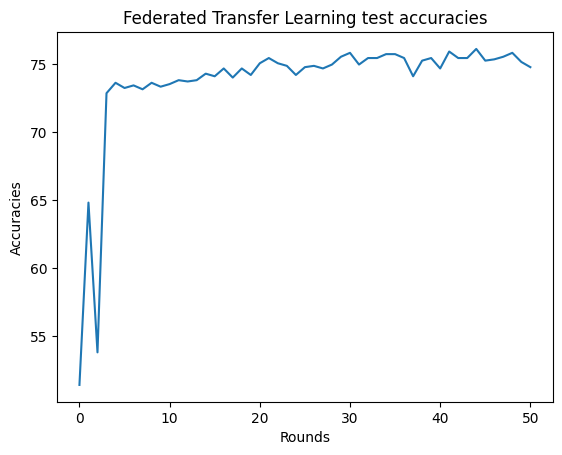

In [17]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')

In [18]:
fl_acc

[tensor(51.4340, device='cuda:0'),
 tensor(64.8184, device='cuda:0'),
 tensor(53.8241, device='cuda:0'),
 tensor(72.8489, device='cuda:0'),
 tensor(73.6138, device='cuda:0'),
 tensor(73.2314, device='cuda:0'),
 tensor(73.4226, device='cuda:0'),
 tensor(73.1358, device='cuda:0'),
 tensor(73.6138, device='cuda:0'),
 tensor(73.3270, device='cuda:0'),
 tensor(73.5182, device='cuda:0'),
 tensor(73.8050, device='cuda:0'),
 tensor(73.7094, device='cuda:0'),
 tensor(73.8050, device='cuda:0'),
 tensor(74.2830, device='cuda:0'),
 tensor(74.0918, device='cuda:0'),
 tensor(74.6654, device='cuda:0'),
 tensor(73.9962, device='cuda:0'),
 tensor(74.6654, device='cuda:0'),
 tensor(74.1874, device='cuda:0'),
 tensor(75.0478, device='cuda:0'),
 tensor(75.4302, device='cuda:0'),
 tensor(75.0478, device='cuda:0'),
 tensor(74.8566, device='cuda:0'),
 tensor(74.1874, device='cuda:0'),
 tensor(74.7610, device='cuda:0'),
 tensor(74.8566, device='cuda:0'),
 tensor(74.6654, device='cuda:0'),
 tensor(74.9522, dev